In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
from biodata.delimited import DelimitedWriter
import numpy as np
import seaborn as sns
from collections import defaultdict, Counter
import matplotlib
import matplotlib.pyplot as plt
import pybedtools
from Bio import SeqIO
from matplotlib.patches import Rectangle, Patch
from biodatatools.utils.common import json_load
import sys
from pathlib import Path
import glob

Matplotlib is building the font cache; this may take a moment.


In [3]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [4]:
sys.path.append(str(Path.cwd().parent))
import utils

In [5]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/databases/"
PROJECT_DIR_d2 = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"

In [6]:
sys.path.append(f"{PROJECT_DIR_s}2_train_models/")
from data_loading import extract_observed_profiles, one_hot_encode

# Candidate selection

In [27]:
# Highlight variants in the same credible set: the one with lower PIP actually actually disrupts the motif and affects the transcription

method = "FINEMAP"
dist = 5e3
inputfile = f"{PROJECT_DIR_d}papers/38014075/GWAS/UKBB_94traits_release1.bed.gz"
df_pip = pd.read_table(inputfile, header=None)
df_pip[(df_pip[10]==method) & (df_pip[11]=="Alb") & (df_pip[0]=="chr1") & (214150445-dist<=df_pip[2]) & (df_pip[2]<=214150445+dist)]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
437039,chr1,214150444.0,214150445.0,chr1:214150445:T:A,rs17712208,T,A,A,UKBB,BOLT,FINEMAP,Alb,chr1:212650821-215650821,0.035316,0.048802,0.006411,57.9510,0.249174,1,0.012932,0.022703,False,False
437054,chr1,214150820.0,214150821.0,chr1:214150821:G:C,rs79687284,G,C,C,UKBB,BOLT,FINEMAP,Alb,chr1:212650821-215650821,0.034922,0.050056,0.006455,60.1414,0.750826,1,0.039899,0.023737,False,False


In [28]:
# region (12): region of the genome fine-mapping in hg19 coordinates
# cs_id (18): ID of 95% credible set (-1 indicates that variant is not in a 95% CS)
# There are two variants in the same credible set

Counter(df_pip[(df_pip[10]==method) & (df_pip[11]=="Alb") & (df_pip[12]=='chr1:212650821-215650821')][18])

Counter({-1: 153, 1: 2})

In [29]:
# hg38

inputfile = f"{PROJECT_DIR_d}papers/38014075/GWAS/UKBB_94traits_release1_filtered_{method}_hg38.bed.gz"
df_pip2 = pd.read_table(inputfile, header=None)
df_select = df_pip2[(df_pip2[5]=="Alb") & (df_pip2[0]=="chr1") & (df_pip2[4].isin(["rs17712208", "rs79687284"]))].reset_index(drop=True).copy()
df_select[6] = df_select[6].astype(float)
df_select

,0,1,2,3,4,5,6
0,chr1,213977101,213977102,chr1:214150445:T:A,rs17712208,Alb,0.249174
1,chr1,213977477,213977478,chr1:214150821:G:C,rs79687284,Alb,0.750826


In [30]:
snps = {}
for _, row in df_select.iterrows():
	# 1-based
	pos = row[2]
	ref, alt = row[3].split(":")[2:]
	rsid = row[4]
	pip = row[6]
	snps[rsid] = (pos, ref, alt, pip)

In [33]:
# We use 1kb input region for prediction

def to_1kb(feature):
	chrom_lengths = pd.read_table(f"{PROJECT_DIR_r}genomes/human/hg38.chrom.sizes.filtered", header=None).set_index(0)[1].to_dict()
	chrom = feature.chrom
	start = int(feature.start)
	end = int(feature.end)
	mid = (start + end) // 2
	new_start = max(0, mid - 500)
	new_end = min(mid + 500, chrom_lengths[chrom])
	return pybedtools.Interval(chrom, new_start, new_end)

In [34]:
beds = json_load(f"{PROJECT_DIR_d2}PROcap/metainfo/sample_beds.json")
bws = json_load(f"{PROJECT_DIR_d2}PROcap/metainfo/sample_bws.json")

In [74]:
s = "EN55"
b1 = pybedtools.BedTool(f"{PROJECT_DIR_d}papers/38014075/GWAS/UKBB_94traits_release1_filtered_{method}_hg38.bed.gz")
b2 = pybedtools.BedTool(beds[s][0])
b2_1kb = b2.each(to_1kb)
overlap = b1.intersect(b2_1kb, wao=True)
pairs = []
for i in overlap:
	rsid = i.fields[4]
	e = "_".join(i.fields[7:10])
	if rsid in ["rs17712208", "rs79687284"] and int(i.fields[-1]) > 0:
		if (rsid, e) not in pairs:
			pairs.append((rsid, e))

In [75]:
# rs17712208: e1 ('chr1_213976621_213977621')
# rs79687284: e1 and e2 ('chr1_213977213_213978213')

pairs

[('rs17712208', 'chr1_213976621_213977621'),
 ('rs79687284', 'chr1_213976621_213977621'),
 ('rs79687284', 'chr1_213977213_213978213')]

In [37]:
es = ['chr1_213976621_213977621', 'chr1_213977213_213978213']

In [89]:
task = "counts"
b3 = pybedtools.BedTool(f"{PROJECT_DIR_o}procapnet/finemo/{s}/{task}/hits_with_motif_names.bed")
overlap = b1.intersect(b3, wao=True)
motifs = defaultdict(dict)
for i in overlap:
	rsid = i.fields[4]
	if rsid in ["rs17712208", "rs79687284"] and int(i.fields[-1]) > 0:
		motif_start, motif_end, motif_name = i.fields[8:11]
		score = i.fields[-5]
		if (rsid, motif_name) not in motifs:
			motifs[(rsid, motif_name)] = (int(motif_start), int(motif_end), motif_name, score)
		if score >= motifs[(rsid, motif_name)][-1]:
			motifs[(rsid, motif_name)] =  (int(motif_start), int(motif_end), motif_name, score)

In [90]:
motifs

defaultdict(dict,
            {('rs17712208', 'HNF1'): (213977099,
              213977113,
              'HNF1',
              '0.75727075')})

# PIP + observed profiles

In [40]:
# Get observed profiles in 2kb region covering both e1 and e2

outputfile = f"{PROJECT_DIR_o}procapnet/prediction/{s}/GWAS_example.bed"
center = 213977400
with DelimitedWriter(outputfile) as dw:
	dw.write(["chr1", center-1000, center+1000])

In [38]:
obs_profs = extract_observed_profiles(bws[s][0],
									bws[s][1],
									f"{PROJECT_DIR_o}procapnet/prediction/{s}/GWAS_example.bed",
									out_window=2000)

== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/prediction/EN55/GWAS_example.bed
Profile length: 2000
Num. Examples: 1


In [7]:
def plot_PROcap(array, ax, width=3):	
	orientations = {"fwd": "#e31a1c", "rev": "#4A4AFF"}
	length = array.shape[1]
	results = [[i, array[0][i], "fwd"] for i in range(length)]
	results += [[i, -array[1][i], "rev"] for i in range(length)]		
		
	df = pd.DataFrame(results, columns=["position", "reads", "orientation"])
	
	for orientation, color in orientations.items():
		df_orientation = df[df["orientation"] == orientation]
		ax.bar(df_orientation["position"], df_orientation["reads"], color=color, align="edge", width=width)

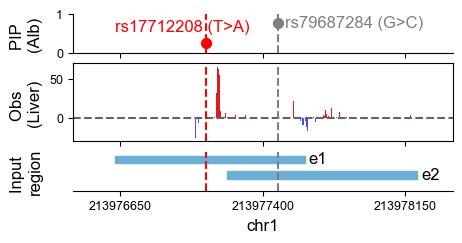

In [41]:
# There are two elements in this region
# Panel 1: PIP
# Panel 2: Liver PRO-cap signals
# Panel 3: 1-kb element for prediction

fig, axes = plt.subplots(3, 1, figsize=(4.9,2.3), height_ratios=[1,2,1])
for n in range(3):
	# pos, PIP
	if n == 0:
		for rsid in snps:
			i = list(snps).index(rsid)
			color = "r" if i == 0 else "grey"
			pos, ref, alt, pip = snps[rsid]
			axes[n].scatter(pos, pip, c=color, s=50)
			x = pos-480 if i == 0 else pos+40
			y = pip+0.3 if i == 0 else pip-0.1
			axes[n].text(x=x, y=y, s=f"{rsid} ({ref}>{alt})", c=color, fontsize=bfontsize)
		ylabel = "PIP \n(Alb)"
		axes[n].spines[["top", "right"]].set_visible(False)
		axes[n].set_ylim([0,1])
	elif n == 1:
		plot_PROcap(obs_profs[0], axes[n])
		axes[n].axhline(y=0, ls="--", c="#636363")
		ylabel = f"Obs \n(Liver)"
	else:
		for e in es:
			chrom, start, end = e.split("_")
			axes[n].add_patch(Rectangle((int(start),0.7-es.index(e)*0.4), 1000, 0.2,
						 edgecolor = "#6baed6",
						 facecolor = "#6baed6",
						 fill=True))
			axes[n].text(x=int(end)+20, y=0.7-es.index(e)*0.4, s=f"e{es.index(e)+1}", fontsize=bfontsize)
		ylabel = "Input \nregion"
		axes[n].spines[["top", "left", "right"]].set_visible(False)
		axes[n].set_yticks([])

	for rsid in snps:
		pos = snps[rsid][0]
		if n in [0,2]:
			pos2 = int(pos)
		else:
			pos2 = int(pos)-center+1000
		color = "r" if list(snps).index(rsid) == 0 else "grey"
		axes[n].axvline(x=pos2+0.5, ls="--", c=color)

	axes[n].set_ylabel(ylabel, fontsize=bfontsize)
	axes[n].yaxis.set_label_coords(-0.08, 0.5)
	
	if n in [0,2]:
		xlim = [center-1000, center+1000]
		xticks = [center-750, center, center+750]
	else:
		xlim = [0,2000]
		xticks = [250,1000,1750]
	axes[n].set_xlim(xlim)
	axes[n].set_xticks(xticks)
	if n == 2:
		axes[n].set_xticklabels(xticks)
		axes[n].set_xlabel(chrom, fontsize=bfontsize)
	else:
		axes[n].set_xticklabels([])
		axes[n].set_xlabel("")
		
	axes[n].tick_params(labelsize=sfontsize)
plt.savefig(f"{PROJECT_DIR_o}figures/Fig4c.pdf", bbox_inches="tight", transparent=True)

# In silico mutagenesis

In [129]:
inputfile = f"{PROJECT_DIR_r}genomes/human/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
with open(inputfile, "r") as f:
    fdict = SeqIO.to_dict(SeqIO.parse(f, "fasta"))

In [264]:
# Get the wild-type and mutant sequence for prediction

outputfile = f"{PROJECT_DIR_o}procapnet/prediction/GWAS_example_seqs.npy"
seqs = []
for rsid, e in pairs:
	chrom, start, end = e.split("_")
	start, end = int(start), int(end)
	wt_seq = fdict[chrom][start:end].seq.upper()
	pos, ref, alt = snps[rsid][:3]
	pos = int(pos)-1
	if fdict[chrom][pos] == ref:
		pos = pos-start
		mt_seq = wt_seq[:pos] + alt + wt_seq[pos+1:]
		for seq in [wt_seq, mt_seq]:
			seqs.append(one_hot_encode(seq).T)
seqs = np.array(seqs)
np.save(outputfile, seqs)

In [42]:
groups = json_load(f"{PROJECT_DIR_d2}PROcap/metainfo/samples.json")
folders = glob.glob(f"{PROJECT_DIR_o}procapnet/deepshap_out/*")
models = [folder.split("/")[-1] for folder in folders if folder.split("/")[-1] in groups["normal_tissues"]]

In [14]:
# Evalute variant effects using various models

script = f"{PROJECT_DIR_s}slurm/predict.sh"
model_type = "strand_merged_umap"
inputfile = f"{PROJECT_DIR_o}procapnet/prediction/GWAS_example_seqs.npy"
for s in models:
	commands = ["bash", script,
				s,
				model_type,
				f"{PROJECT_DIR_o}procapnet/",
				inputfile,
				f"{PROJECT_DIR_o}procapnet/prediction/{s}/GWAS_example.",
				str(models.index(s)%2)
				]
	print(" ".join(commands))

bash /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/predict.sh EN5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ /home/yc2553/projects/HEA/output/procapnet/prediction/GWAS_example_seqs.npy /home/yc2553/projects/HEA/output/procapnet/prediction/EN5/GWAS_example. 0
bash /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/predict.sh BCT5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ /home/yc2553/projects/HEA/output/procapnet/prediction/GWAS_example_seqs.npy /home/yc2553/projects/HEA/output/procapnet/prediction/BCT5/GWAS_example. 1
bash /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/predict.sh EN55 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ /home/yc2553/projects/HEA/output/procapnet/prediction/GWAS_example_seqs.npy /home/yc2553/projects/HEA/output/procapnet/prediction/EN55/GWAS_example. 0
bash /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/sl

In [43]:
# Count task: calculate |log2FC|

results = []
for s in models:
	data = np.load(f"{PROJECT_DIR_o}procapnet/prediction/{s}/GWAS_example.pred_counts.npy")
	data = np.exp(data).flatten().tolist()
	for rsid, e in pairs:
		n = pairs.index((rsid, e))
		# mt/wt
		logFC = np.log2(data[n*2+1]/data[n*2])
		model = "Liver" if s == "EN55" else "Others"
		results.append([model, f"{rsid}-e{es.index(e)+1}", logFC])
df_FC = pd.DataFrame(results, columns=["model", "pair", "logFC"])
df_FC.head(2)

,model,pair,logFC
0,Others,rs17712208-e1,-0.467436
1,Others,rs79687284-e1,-0.013014


In [44]:
cdict = json_load(f"{PROJECT_DIR_d2}PROcap/metainfo/color_codes.json")

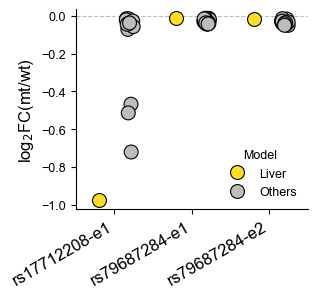

In [45]:
fig, ax = plt.subplots(figsize=(3,2.6))
g = sns.stripplot(data=df_FC, x="pair", y="logFC", edgecolor="black", linewidth=lw,
				  hue="model", hue_order=["Liver", "Others"], palette=[cdict["Liver"], "#bdbdbd"], 
				  s=10, dodge=True, ax=ax)
g.spines[["top","right"]].set_visible(False)
g.legend(title="Model", title_fontsize=sfontsize, fontsize=sfontsize, frameon=False)
g.axhline(y=0, ls="--", lw=lw, c="#bdbdbd")
g.set_xlabel("")
g.tick_params(axis="x", labelsize=bfontsize, rotation=30)
for label in g.get_xticklabels():
    label.set_horizontalalignment("right")
g.set_ylabel("log$_2$FC(mt/wt)", fontsize=bfontsize)
g.tick_params(axis="y", labelsize=sfontsize)
plt.savefig(f"{PROJECT_DIR_o}figures/Fig4d.pdf", bbox_inches="tight", transparent=True)

# Get contribution scores

In [59]:
# Get contribution scores; add GPU ID

script = f"{PROJECT_DIR_s}slurm/interpret_any.sh"
inputfile = f"{PROJECT_DIR_o}procapnet/prediction/GWAS_example_seqs.npy"
s = "EN55"
commands = ["bash", script,
			s,
			model_type,
			f"{PROJECT_DIR_o}procapnet/",
			inputfile,
			f"{PROJECT_DIR_o}procapnet/prediction/{s}/GWAS_example.",
			]
print(" ".join(commands))

bash /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/interpret_any.sh EN55 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ /home/yc2553/projects/HEA/output/procapnet/prediction/GWAS_example_seqs.npy /home/yc2553/projects/HEA/output/procapnet/prediction/EN55/GWAS_example.


# Browser shots

In [18]:
def plot_scores(array, ax):
	utils.plot_weights(array[:, 250:750], ax)
	ax.ticklabel_format(style="sci", axis="y", scilimits=(0,0), useMathText=True)

In [111]:
def plot_example(e, snp, motif, pred_profs, scores, outputfile, xlims=None, ylims=None, yticks=None):
	fig, ax = plt.subplots(4, 1, figsize=(4.8,2.8))

	chrom, start, end = e.split("_")
	snp_pos = int(snp[0]) - 1 - int(start) - 250
	m_start, m_end, motif_name = motif[:-1]
	m_start2 = m_start - int(start) - 250	
	m_end2 = m_start2 + m_end - m_start
	
	for k in range(4):
		# Predicted PROcap signals (wt)
		if k == 0:
			plot_PROcap(pred_profs[0], ax[k], 1)
			ylabel = "Pred\n(wt)"
		# Contribution score (wt)
		elif k == 1:
			plot_scores(scores[0], ax[k])
			ylabel = "Score\n(wt)"
		# Predicted PROcap signals (mt)
		elif k == 2:
			plot_PROcap(pred_profs[1], ax[k], 1)
			ylabel = "Pred\n(mt)"
			ax[k].axhline(y=0, ls="--", c="r")
		# Contribution score (mt)
		else:
			plot_scores(scores[1], ax[k])
			ylabel = "Score\n(mt)"
			
		ax[k].set_ylabel(ylabel, fontsize=bfontsize)
		ax[k].yaxis.set_label_coords(-0.1, 0.5)
		ax[k].axvline(x=snp_pos+0.5, ls="--", c="r", lw=lw)

		if xlims:
			ax[k].set_xlim(xlims)
			nticks = (xlims[1]-xlims[0])//100+1
			xticks = [xlims[0]+n*100 for n in range(nticks)]
			# In the center
			ax[k].set_xticks([x+0.5 for x in xticks])
			if k == 3:
				# Genomic coordinates: 1-based
				xticklabels = [int(start)+250+x+1 for x in xticks]
				ax[k].set_xticklabels(xticklabels)
				ax[k].set_xlabel(chrom, fontsize=bfontsize)
			else:
				ax[k].set_xticklabels([])
				ax[k].set_xlabel("")

		if ylims:
			# Predicted PROcap signals 
			if k in [0,2]:
				ylim = ylims[0]
				ytick = yticks[0]
				ax[k].axhline(y=0, ls="--", c="#636363")
			# Contribution scores
			else:
				ylim = ylims[1]
				ytick = yticks[1]
				ax[k].ticklabel_format(style="plain", axis="y")
				ax[k].fill_betweenx(y=ylim, x1=m_start2, x2=m_end2, color=cdict["Liver"], alpha=0.3)
				if k == 1:
					ax[k].text(x=m_start2+20, y=ylim[1]*0.5, s=motif_name, fontsize=bfontsize, color=cdict["Liver"])
				
			ax[k].set_ylim(ylim)
			ax[k].set_yticks(ytick)
		ax[k].tick_params(labelsize=sfontsize)
		
	plt.subplots_adjust(hspace=0.2)
	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

In [60]:
pred_profiles = np.load(f"{PROJECT_DIR_o}procapnet/prediction/{s}/GWAS_example.pred_profiles.npy")
pred_counts = np.load(f"{PROJECT_DIR_o}procapnet/prediction/{s}/GWAS_example.pred_counts.npy")
scaled_pred_profiles = pred_profiles * np.exp(pred_counts)[..., None]
scores = np.load(f"{PROJECT_DIR_o}procapnet/prediction/{s}/GWAS_example.count_scores.npy")

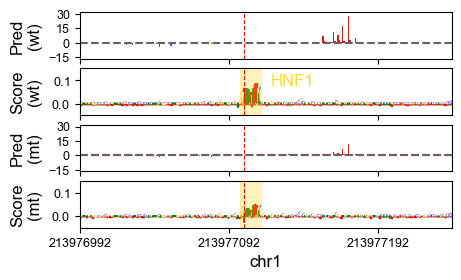

In [114]:
xlims = [120,370]
ylims = [[-17,32], [-0.05, 0.15]]
yticks = [[-15,0,15,30], [0,0.1]]
outputfile = f"{PROJECT_DIR_o}figures/Fig4e.pdf"
plot_example(es[0], snps["rs17712208"], motifs[('rs17712208', 'HNF1')], scaled_pred_profiles[:2], scores[:2], outputfile, xlims, ylims, yticks)